In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import tensorflow as tf

import itertools


## Early  preprocessing:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
df_all = pd.read_csv('/data/Data_Entry_2017.csv')
image_paths = {os.path.basename(x): x for x in 
               glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(image_paths), ', Total Headers', df_all.shape[0])
df_all['path'] = df_all['Image Index'].map(image_paths.get)
df_all.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
6349,00001715_000.png,No Finding,0,1715,65,M,PA,2992,2991,0.143,0.143,NaN,/data/images_002/images/00001715_000.png
38825,00010142_000.png,No Finding,0,10142,80,F,AP,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010142_000.png
59802,00014764_001.png,Infiltration,1,14764,34,F,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014764_001.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

finding_names = list(set(l for findings in df_all["Finding Labels"] for l in findings.split('|')))
print("Finding labels that occur in the data set:\n\n\t"+'\n\t'.join(finding_names))


for finding_name in finding_names:
    df_all[finding_name] = df_all["Finding Labels"].apply(lambda x : int(finding_name in x.split('|')))

df_all.sample(3)

Finding labels that occur in the data set:

	Atelectasis
	Cardiomegaly
	Effusion
	Emphysema
	Fibrosis
	Hernia
	No Finding
	Infiltration
	Consolidation
	Nodule
	Pneumothorax
	Edema
	Mass
	Pleural_Thickening
	Pneumonia


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,No Finding,Infiltration,Consolidation,Nodule,Pneumothorax,Edema,Mass,Pleural_Thickening,Pneumonia
58341,00014427_007.png,Nodule,7,14427,56,M,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,0
29390,00007650_001.png,Pneumothorax,1,7650,33,F,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,0
49099,00012454_000.png,No Finding,0,12454,44,F,PA,2500,2828,0.139,...,0,1,0,0,0,0,0,0,0,0


In [4]:
# it will also be handy to have some of this metadata in numerical form
df_all['sex'] = df_all['Patient Gender'].apply(lambda x : float(x=='F'))
df_all['orientation'] = df_all['View Position'].apply(lambda x : float(x=='PA'))

## Create training and testing data:

In [5]:
# fraction of validation set that is negative cases. guessing what it might be in clinical setting.
frac_neg_valid = 0.9 

num_pos_all = sum(df_all['Pneumonia']==1)
num_pos_valid = int(0.2*num_pos_all)
num_neg_valid = int(frac_neg_valid/ (1-frac_neg_valid) * num_pos_valid)
num_pos_train = num_pos_all - num_pos_valid
num_neg_train = num_pos_train # training set will have 50-50 split of pos and neg cases

df_pos_all = df_all[df_all['Pneumonia']==1]
df_pos_all = df_pos_all.sample(frac=1.0) # shuffle
df_pos_valid = df_pos_all.iloc[:num_pos_valid]
df_pos_train = df_pos_all.iloc[num_pos_valid:]
assert(len(df_pos_train)==num_pos_train)

df_neg_all = df_all[df_all['Pneumonia']==0]
df_neg_all = df_neg_all.sample(frac=1.0) # shuffle
df_neg_valid = df_neg_all.iloc[:num_neg_valid]
df_neg_train_pool = df_neg_all.iloc[num_neg_valid:] # see make_df_train docstring below

# validation data is now fixed throughout training:
df_valid = pd.concat([df_pos_valid,df_neg_valid]).sample(frac=1.0)  

# training data has fixed set of positive cases, but let's allow switching out negative cases for fresh ones
def make_df_train(df_pos_train, df_neg_train_pool):
    """Return training data made using the fixed df_pos_train and a random selection
    of an equal number of entries from the fixed df_neg_train_pool. It will be a
    50-50 split between positive and negative cases, but the negative cases selected will vary each time 
    this function is called."""
    df_neg_train_pool = df_neg_train_pool.sample(frac=1.0) # shuffle
    df_neg_train = df_neg_train_pool[:num_neg_train]
    return pd.concat([df_pos_train,df_neg_train]).sample(frac=1.0)

# just sanity-checking the function make_df_train
assert(sum(make_df_train(df_pos_train, df_neg_train_pool)['Pneumonia']==1) == num_pos_train)
assert(sum(make_df_train(df_pos_train, df_neg_train_pool)['Pneumonia']==0) == num_neg_train)

print("The validation set consists of {} images, of which {} are positive cases.".format(
        num_pos_valid + num_neg_valid,
        num_pos_valid
    )
)
print("The training set will consist of {} images, of which {} are positive cases.".format(
        num_pos_train + num_neg_train,
        num_pos_train
    )
)

The validation set consists of 2860 images, of which 286 are positive cases.
The training set will consist of 2290 images, of which 1145 are positive cases.


# Now we can begin our model-building & training

image augmentation

In [6]:
idg_train = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.2,
    channel_shift_range=0.0,
    fill_mode="constant",
    cval=0, # black background behind rotation/shift
    horizontal_flip=False, # see comment below
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)

idg_valid = tf.keras.preprocessing.image.ImageDataGenerator()


I do not think horizontal flip makes sense as an augmentation here. It's true that there are AP and PA orientations, but those are front-back flipped which is not the same to an X-ray as a left-right flip (because X-rays will get obstructed by objects in a different order). Human anatomy is not left-right symmetric. Unless a patient has the rare conditon Situs Inversus, their heart will always be on the same side in the X-ray.

In [7]:
# The following column names are the ones whose binary labels our model will try to predict
# Pneumonia is first in the list, for convenience
# "No finding" doesn't need to be predicted, since it is represented by the case in which all outputs are 0

model_y_col = ['Pneumonia'] + [fn for fn in finding_names if fn not in ['No Finding', 'Pneumonia']]
print('\n'.join(model_y_col))

Pneumonia
Atelectasis
Cardiomegaly
Effusion
Emphysema
Fibrosis
Hernia
Infiltration
Consolidation
Nodule
Pneumothorax
Edema
Mass
Pleural_Thickening


In the following cell you can see that the training will be based on ALL the finding labels, not just pneumonia.
This way the network might learn more important higher level features than if it were just trained on pneumonia,
which I suspect can make it perform better on pneumonia.

Validation will just focus on pneumonia. In the end, I want the model that is best at pneumonia detection.

In [8]:
img_target_size = (224,224)

def img_from_path(path):
    return tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(path, target_size=img_target_size))

def dataframe_iterator_train(batch_size):
    df_neg_train = df_neg_train_pool.sample(num_neg_train) # Note that we will pick new negatives on each epoch
    df_train = pd.concat([df_neg_train,df_pos_train]).sample(frac=1.0)
    num_batches = int(np.ceil(len(df_train)/batch_size))
    for batch_number in range(num_batches):
        rows = df_train.iloc[batch_size*batch_number:batch_size*(batch_number+1)]
        imgs = np.array([
            idg_train.apply_transform(img_from_path(row.path) ,idg_train.get_random_transform(img_target_size))
            for _,row in rows.iterrows()
        ])
        infos = rows[['sex','orientation']].to_numpy(dtype='float32')
        y = rows[model_y_col].to_numpy(dtype='float32')
        yield imgs, infos, y

def dataframe_iterator_valid(batch_size):
    num_batches = int(np.ceil(len(df_valid)/batch_size))
    for batch_number in range(num_batches):
        rows = df_valid.iloc[batch_size*batch_number:batch_size*(batch_number+1)]
        imgs = np.array([
            img_from_path(row.path)
            for _,row in rows.iterrows()
        ])
        infos = rows[['sex','orientation']].to_numpy(dtype='float32')
        y = rows['Pneumonia'].to_numpy(dtype='float32')
        yield imgs, infos, y
        

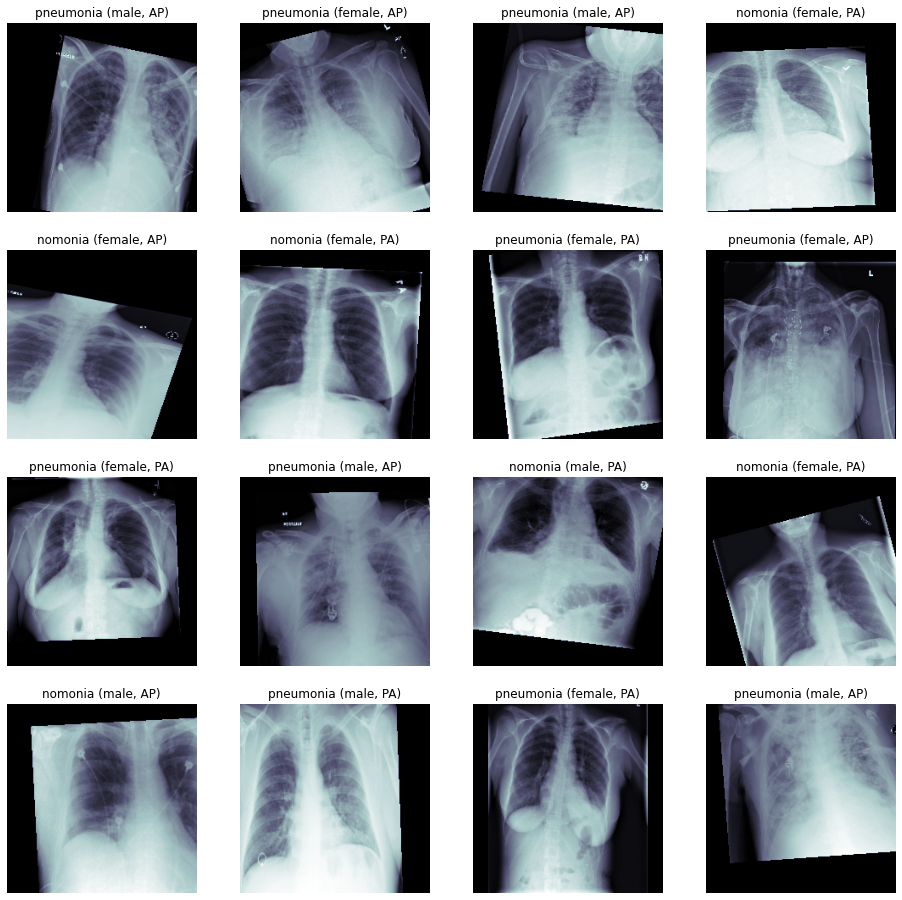

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x_img, t_x_info, t_y = next(dataframe_iterator_train(32))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x_img, c_x_info, c_y, c_ax) in zip(t_x_img, t_x_info, t_y, m_axs.flatten()):
    c_ax.imshow(c_x_img[:,:,0], cmap = 'bone')
    c_ax.set_title(
        ('pneumonia' if c_y[0]==1.0 else 'nomonia') + ' (' +
        ('male' if c_x_info[0]==0.0 else 'female') + ', ' +
        ('PA' if c_x_info[1]==1.0 else 'AP') + ')'
    )
    c_ax.axis('off')

## Build model: 

In [10]:
vgg_model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
)

553467904/553467096 [==============================] - 8s 0us/step


In [11]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
for layer in vgg_model.layers[:19]: # 15 to freeze all but last conv layers, 19 to freez all conv layers
    layer.trainable = False

vgg_model_truncated = tf.keras.Model(vgg_model.input,vgg_model.layers[19].output)

vgg_model_truncated.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
img_input = tf.keras.Input(shape=(224,224,3), dtype='float32')
info_input = tf.keras.Input(shape=(2), dtype='float32') # info includes patient sex and xray orientation
x = vgg_model_truncated(img_input)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Concatenate()([x,info_input])

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(len(model_y_col), kernel_regularizer=tf.keras.regularizers.l2(0.05))(x) 
# final output is logits, needs sigmoid to be applied still
outputs = x
model = tf.keras.Model([img_input, info_input], outputs)

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 25088)        14714688    input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 25088)        0           model[1][0]                      
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2)]          0                                            
____________________________________________________________________________________________

In [15]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# The following loss function is a weighted mean of binary cross entropy losses
# The weighting is just to make pneumonia more important
# expected shape of y's is (batch size, number of labels)
def loss_fn(y_true, y_pred):
    pneumonia_loss = bce(y_true[:,0], y_pred[:,0])
    other_loss = sum(bce(y_true[:,i], y_pred[:,i]) for i in range(1,len(model_y_col)))
    
    # Tweak the weight of pneumonia here
    pneumonia_weight = 3.0
    return pneumonia_weight * pneumonia_loss + other_loss / (pneumonia_weight + len(model_y_col) - 1) 

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [16]:
@tf.function
def train_on_batch(t_x_img, t_x_info, t_y):
    with tf.GradientTape() as tape:
        logits = model([t_x_img, t_x_info], training=True)
        loss = loss_fn(t_y, logits)
        gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    return loss

@tf.function
def validation_loss(v_x_img, v_x_info, v_y):
    logits = model([v_x_img, v_x_info], training=False)[:,0] # take pneumonia prediction only
    loss = bce(v_y, logits)
    return loss

@tf.function
def inference_on_batch(x_img, x_info):
    logits = model([x_img, x_info], training=False)[:,0] # take pneumonia prediction only
    return tf.sigmoid(logits)

### Training

In [17]:
t_losses_by_batch = []
tv_losses_by_epoch = []
min_v_loss = float('inf')
num_epochs_since_last_improvement = 0
patience = 6 # how many epochs of no improvement before we quit
best_model_weights = model.get_weights()
epoch = 0
print_every = 20 # print every this many batches
batch_size = 32
while True:
    
    batch_count = 0
    
    for t_x_img, t_x_info, t_y in dataframe_iterator_train(batch_size):
        
        
        t_loss = train_on_batch(t_x_img, t_x_info, t_y).numpy()
        t_losses_by_batch.append(t_loss)
    
        if batch_count % print_every == 0:
            print("Batch {} of epoch {}; training loss: {}".format(
                    batch_count, epoch, np.mean(t_losses_by_batch[-print_every:])
                )
            )
        
        batch_count += 1
    
    t_loss = np.mean(t_losses_by_batch[-batch_count:])
    
    v_loss = 0.0
    num_validation_batches = 48
    v_batch_count=0
    for v_x_img, v_x_info, v_y in dataframe_iterator_valid(batch_size):
        v_loss += validation_loss(v_x_img, v_x_info, v_y).numpy()
        v_batch_count += 1
        if v_batch_count >= num_validation_batches:
            break
    v_loss /= float(num_validation_batches)
    
    tv_losses_by_epoch.append([t_loss,v_loss])
    
    print("Epoch {} complete; average training loss {}; current validation loss: {}".format(
        epoch, t_loss, v_loss
    ))
    
    if v_loss < min_v_loss:
        min_v_loss = v_loss
        num_epochs_since_last_improvement = 0
        best_model_weights = model.get_weights()
    else:
        num_epochs_since_last_improvement += 1
    
    if num_epochs_since_last_improvement >= patience:
        break
        
    epoch += 1
    
model.set_weights(best_model_weights)

Batch 0 of epoch 0; training loss: 19.26226806640625
Batch 20 of epoch 0; training loss: 11.720602989196777
Batch 40 of epoch 0; training loss: 8.418025970458984
Batch 60 of epoch 0; training loss: 6.6476593017578125
Epoch 0 complete; average training loss 8.664288520812988; current validation loss: 0.7326263139645258
Batch 0 of epoch 1; training loss: 6.277094841003418
Batch 20 of epoch 1; training loss: 5.621781349182129
Batch 40 of epoch 1; training loss: 4.862654685974121
Batch 60 of epoch 1; training loss: 4.202635765075684
Epoch 1 complete; average training loss 4.81002140045166; current validation loss: 0.7840890375276407
Batch 0 of epoch 2; training loss: 4.309448719024658
Batch 20 of epoch 2; training loss: 3.7672476768493652
Batch 40 of epoch 2; training loss: 3.688138246536255
Batch 60 of epoch 2; training loss: 3.2538161277770996
Epoch 2 complete; average training loss 3.578744649887085; current validation loss: 0.6742452072600523
Batch 0 of epoch 3; training loss: 3.338783

In [18]:
# Do inference on all the validation data and collect the results

probabilities = np.array([], dtype='float32')
ground_truth = np.array([], dtype='float32')
batch_count = 0
for v_x_img, v_x_info, v_y in dataframe_iterator_valid(64):
    probabilities = np.concatenate((probabilities, inference_on_batch(v_x_img, v_x_info)))
    ground_truth = np.concatenate((ground_truth, v_y))
    batch_count += 1
    if batch_count%10==0:
        print("worked through batch {}".format(batch_count))

worked through batch 10
worked through batch 20
worked through batch 30
worked through batch 40


In [19]:
def stats_for_threshold(threshold):
    probabilities >= threshold
    num_TP = ((probabilities >= threshold) & (ground_truth == 1.0)).sum()
    num_FP = ((probabilities >= threshold) & (ground_truth == 0.0)).sum()
    num_TN = ((probabilities < threshold) & (ground_truth == 0.0)).sum()
    num_FN = ((probabilities < threshold) & (ground_truth == 1.0)).sum()
    sensitivity = num_TP / (num_TP + num_FN) if (num_TP + num_FN) > 0 else float('nan')
    specificity = num_TN / (num_TN + num_FP) if (num_TN + num_FP) > 0 else float('nan')
    precision = num_TP / (num_TP + num_FP) if (num_TP + num_FP) > 0 else float('nan')
    false_pos_rate = num_FP/ (num_FP + num_TN) if (num_FP + num_TN) > 0 else float('nan')
    return sensitivity, specificity, precision, false_pos_rate

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

training history, ROC curve, and precision recall curve:

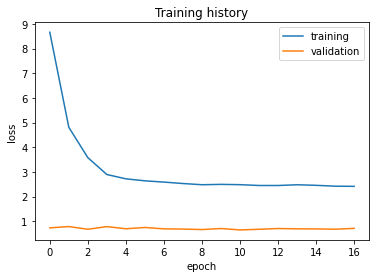

(Note that training and validation losses are computed differently and should not be compared to each other.)


In [20]:
tv_losses_by_epoch_np = np.array(tv_losses_by_epoch)
plt.plot(tv_losses_by_epoch_np[:,0], label='training')
plt.plot(tv_losses_by_epoch_np[:,1], label='validation')
plt.title('Training history')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
print("(Note that training and validation losses are computed differently and should not be compared to each other.)")

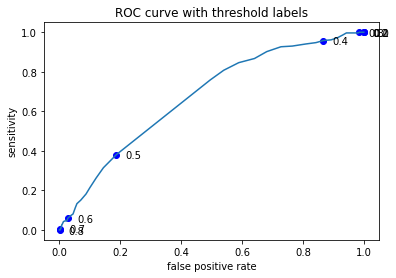

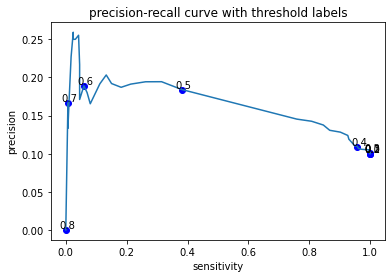

In [20]:
thresholds = np.arange(0.0, 1.0, 0.01)
stats = np.array([stats_for_threshold(threshold) for threshold in thresholds])
sensitivities = stats[:,0]
specificities = stats[:,1]
precisions = stats[:,2]
fprs = stats[:,3]
not_nan_mask = (~np.isnan(precisions)) & (~np.isnan(sensitivities)) & (~np.isnan(fprs)) & (~np.isnan(specificities))
thresholds = thresholds[not_nan_mask]
sensitivities = sensitivities[not_nan_mask]
specificities = specificities[not_nan_mask]
precisions = precisions[not_nan_mask]
fprs = fprs[not_nan_mask]

plt.plot(fprs, sensitivities)
plt.xlabel('false positive rate')
plt.ylabel('sensitivity')
plt.title('ROC curve with threshold labels')
for i in range(0,len(thresholds),10):
    x = fprs[i]
    y = sensitivities[i]
    plt.scatter(x,y,color='blue')
    plt.text(x+0.03,y-0.02,str(round(thresholds[i],3)))
plt.show()

plt.plot(sensitivities, precisions)
plt.xlabel('sensitivity')
plt.ylabel('precision')
plt.title('precision-recall curve with threshold labels')
for i in range(0,len(thresholds),10):
    x = sensitivities[i]
    y = precisions[i]
    plt.scatter(x,y,color='blue')
    plt.text(x-0.02,y+0.002,str(round(thresholds[i],3)))
plt.show()

In [21]:
def optimal_threshold_for_fbeta(beta):
    fscores = np.array([[thres,(1+beta**2)*(prec*sens)/((beta**2)*prec+sens)]
                        for thres, prec, sens in zip(thresholds, precisions, sensitivities)
                        if not (prec==0.0 and sens==0.0)
                       ])
    return fscores[fscores[:,1].argmax(),0]

# Let's say we consider sensitivity to be twice as important as precision
threshold = optimal_threshold_for_fbeta(2)

sensitivity, specificity, precision, false_pos_rate = stats_for_threshold(threshold)

print("""The optimal threshold is {:.2f}, which gives us
       sensitivity\t{:.2f},
       specificity\t{:.2f},
       precision\t{:.2f}
       """.format(
    threshold, sensitivity, specificity, precision
))

The optimal threshold is 0.48, which gives us
       sensitivity	0.81,
       specificity	0.46,
       precision	0.14
       


Here's the plot of F1 and F2 scores against threshold:

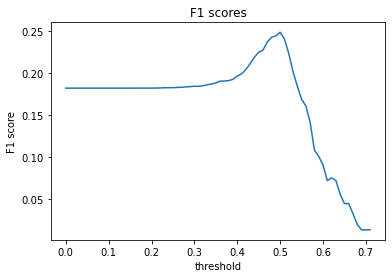

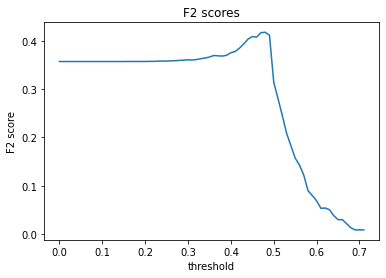

In [28]:
fscores = lambda beta : np.array([[thres,(1+beta**2)*(prec*sens)/((beta**2)*prec+sens)]
                                    for thres, prec, sens in zip(thresholds, precisions, sensitivities)
                                    if not (prec==0.0 and sens==0.0)
                                 ])
f1 = fscores(1)
plt.plot(f1[:,0],f1[:,1])
plt.xlabel('threshold')
plt.ylabel('F1 score')
plt.title('F1 scores')
plt.show()

f2 = fscores(2)
plt.plot(f2[:,0],f2[:,1])
plt.xlabel('threshold')
plt.ylabel('F2 score')
plt.title('F2 scores')
plt.show()

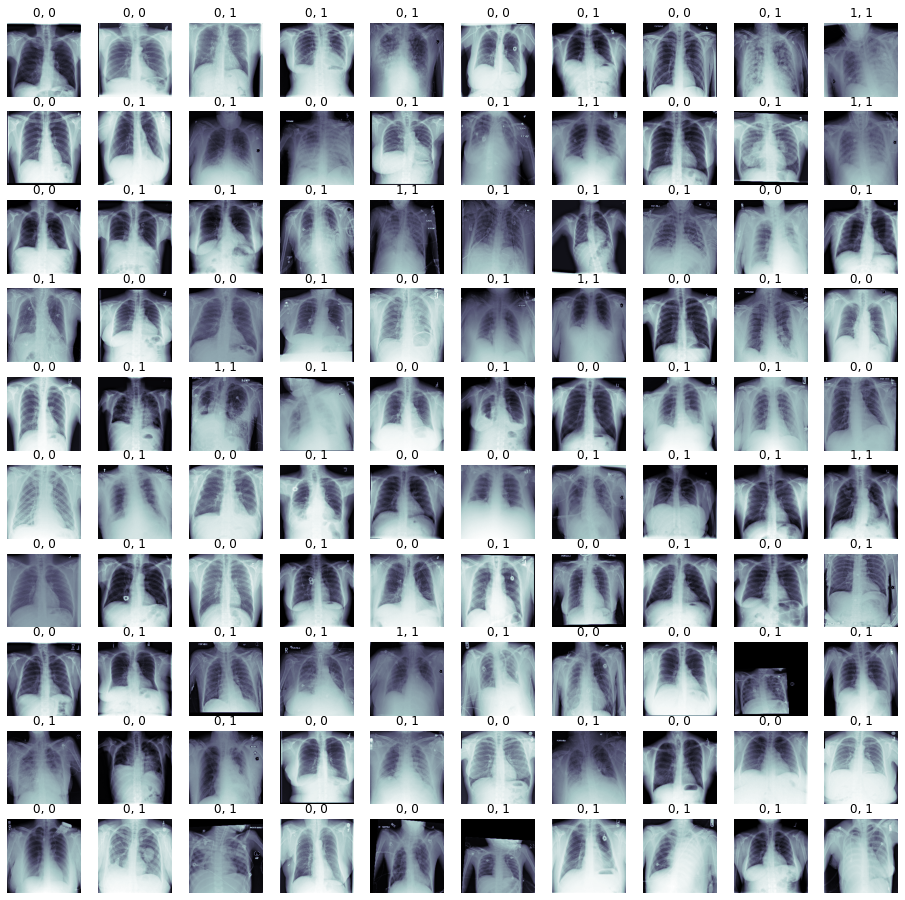

In [29]:
## Let's look at some examples of true vs. predicted with our best model: 

v_x_img, v_x_info, v_y = next(dataframe_iterator_valid(100))
pred_Y = inference_on_batch(v_x_img, v_x_info)

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x_img, c_y, c_ax) in zip(v_x_img, v_y, m_axs.flatten()):
    c_ax.imshow(c_x_img[:,:,0], cmap = 'bone')
    if c_y == 1.0: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [24]:
## Save model architecture to a json:

model_json = model.to_json()
with open("model_architecture7.json", "w") as json_file:
    json_file.write(model_json)
    
# Save model weights:

model.save_weights("model_weights7.h5")

In [17]:
# Optionally run this cell at any time to load the saved model

with open("model_architecture7.json", "r") as json_file:
    model_json = json_file.read()
    model = tf.keras.models.model_from_json(model_json)

model.load_weights("model_weights7.h5")